In [1]:
from neo.core import SpikeTrain
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import pair_confusion_matrix,contingency_matrix
from sklearn.metrics.cluster import rand_score
from statannotations.Annotator import Annotator
from tqdm import tqdm
import elephant as eph
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantities as q
import seaborn as sns

%config Completer.use_jedi = False

mpl.rcParams.update({'font.size': 20})
recalculate=False

In [2]:
def rankbiserial(x,y,resamples=5000,ci=0.95):
    x = x.flatten()
    y = y.flatten()
    idxs = np.vstack([np.arange(x.shape[0]),np.random.choice(x.shape[0],size=(resamples-1,x.shape[0]),replace=True)])
    corrs = []
    for idx in idxs:
        d = x[idx]-y[idx]
        r = stats.rankdata(abs(d))
        r_plus = np.sum((d > 0) * r)
        r_minus = np.sum((d < 0) * r)
        p_plus = r_plus/(r_plus+r_minus)
        p_minus = r_minus/(r_plus+r_minus)
        corrs.append(p_plus-p_minus)
    if ci=='sd':
        return corrs[0],np.std(corrs)
    else:
        return corrs[0],(np.quantile(corrs,1-ci),np.quantile(corrs,ci))

def eval_dynamics(graphno,binsize=200,binarize=False):
    mat = np.loadtxt(f'../modules/networks/matrix_{graphno}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{graphno}_modules.csv')
    order = np.argsort(module)

    all_events = []
    for pertseed in [59428,13674,84932,72957,85036]:
        events = np.load(f"../data/30LN/LN30_events_{graphno}_{pertseed}.npy",allow_pickle=True)
        all_events.append(events)
    all_events = np.array(all_events,dtype=object)
    
    all_traces = []
    for pertseed in [59428,13674,84932,72957,85036]:
        traces = np.load(f"../data/30LN/LN30_data_{graphno}_{pertseed}.npy",allow_pickle=True)
        traces = np.append(traces,np.median(traces)*np.ones((5,1,30)),axis=1)
        traces = np.apply_along_axis(lambda v: np.convolve(v,1000*np.ones(binsize)/binsize,)[:v.shape[0]],1,np.logical_and(traces[:,:-1,:]<-20,traces[:,1:,:]>=-20))
        if binarize:
            all_traces.append(traces>0)
        else:    
            all_traces.append(traces)
    all_traces = np.concatenate(all_traces,axis=1)

    dist = []
    for rep in tqdm(range(5)):
        spike_times = []
        for i in range(30):
            spike_times.append(SpikeTrain(np.concatenate([all_events[0,rep,i],
                                               all_events[1,rep,i]+7000,
                                               all_events[2,rep,i]+14000,
                                               all_events[3,rep,i]+21000,
                                               all_events[4,rep,i]+28000
                                                         ])*q.ms,t_stop=35000*q.ms))
        
        spike_times = np.array(spike_times)
        bst = eph.conversion.BinnedSpikeTrain(list(spike_times),bin_size=50*q.ms)
        pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
        dist.append(np.nan_to_num(pearson_correlation))
    axs = []
    for i in np.unique(module):
        temp = np.mean(all_traces[:,:,np.arange(30)[module==i]],axis=2)
        axs.append(temp)
    axs = np.transpose(np.array(axs),(1,0,2))
    distance_matrix = np.array(dist)
    pearson_correlation = distance_matrix
    
    return mat,module,order,pearson_correlation,axs

# LN Correlation Communities (Fig 4a,b)

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 29.67it/s]


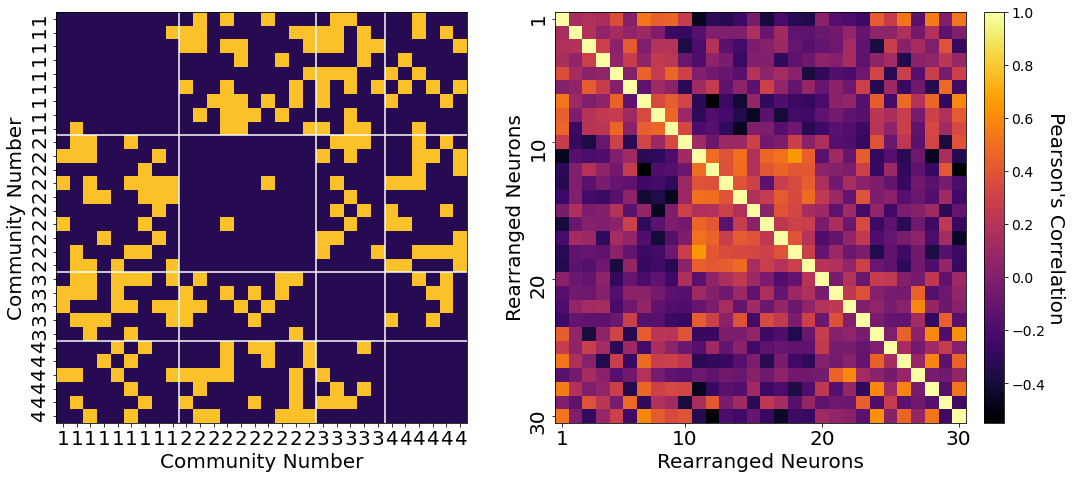

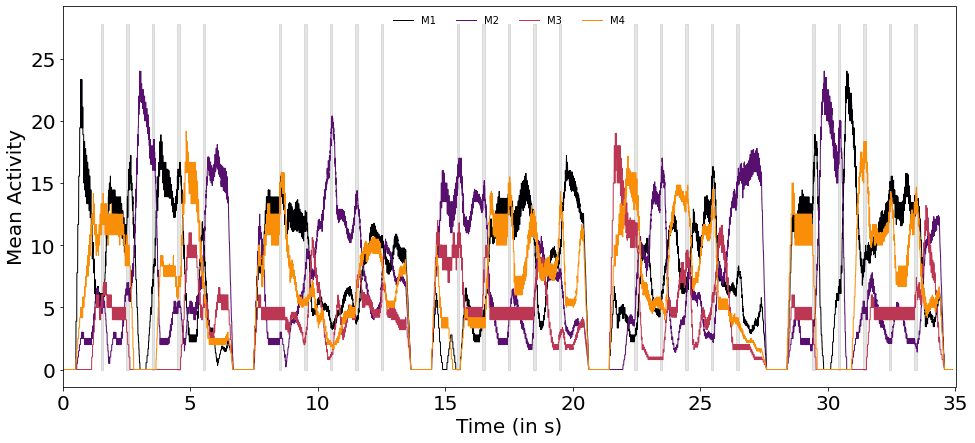

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 37.63it/s]


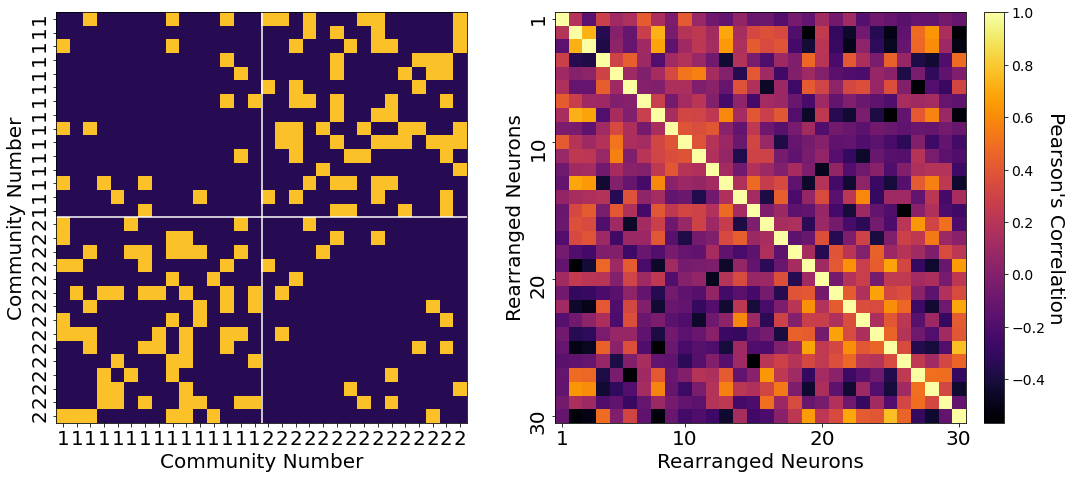

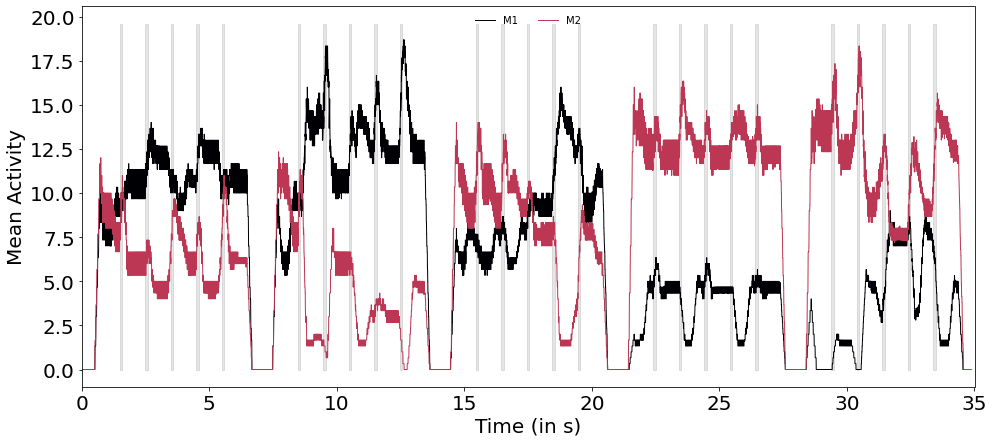

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 5/5 [00:00<00:00, 29.11it/s]


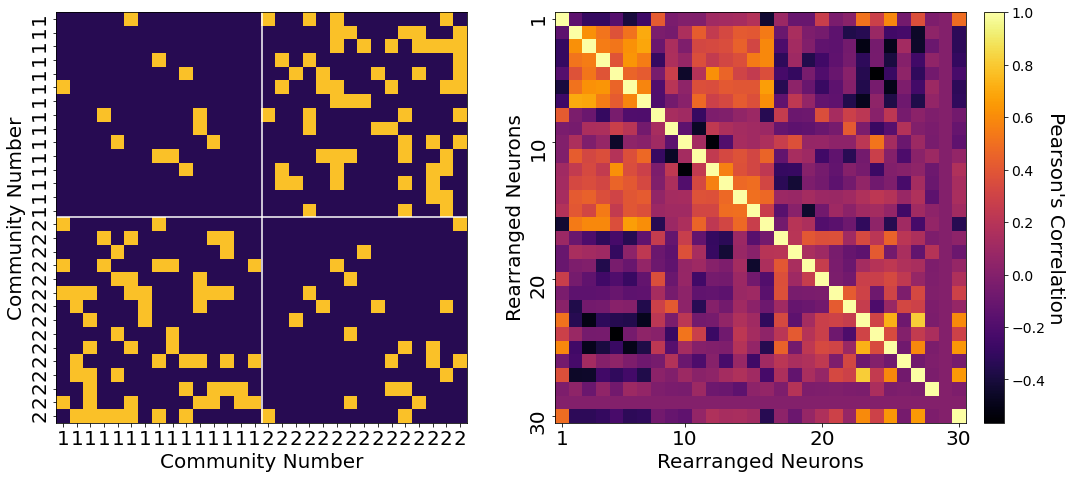

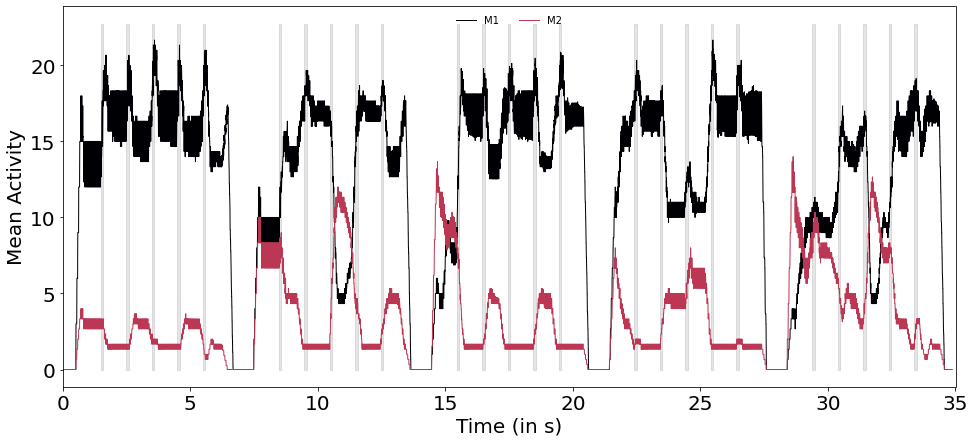

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


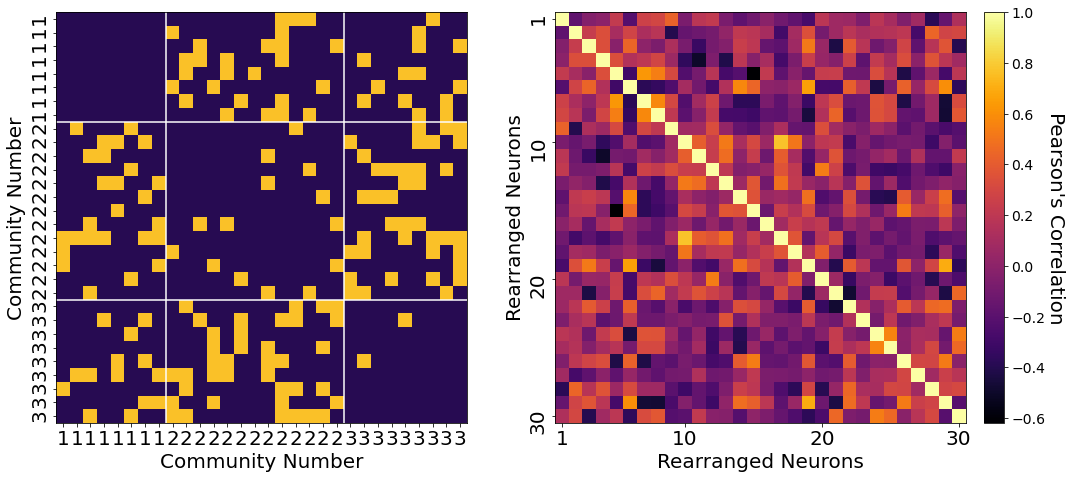

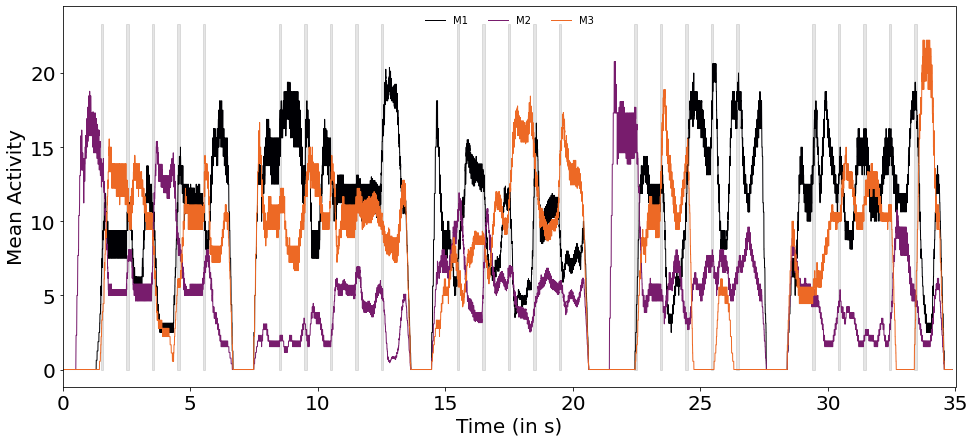

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 22.84it/s]


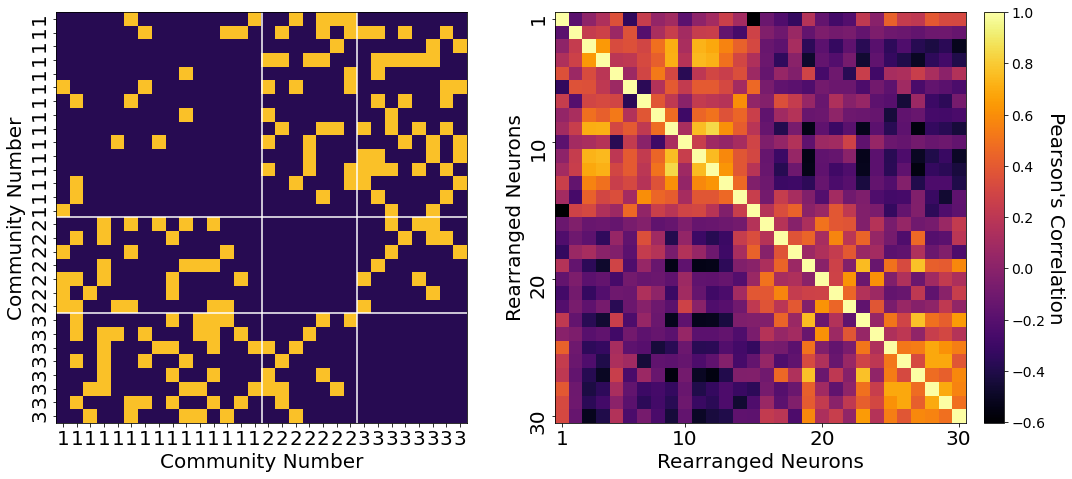

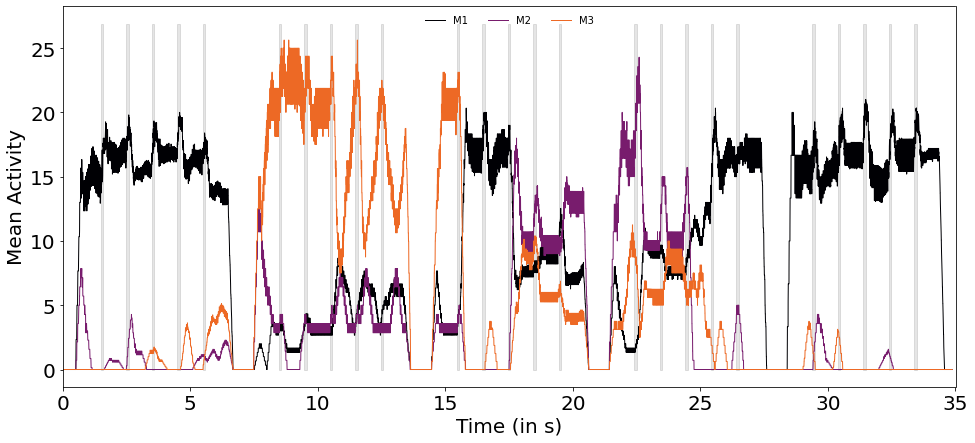

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


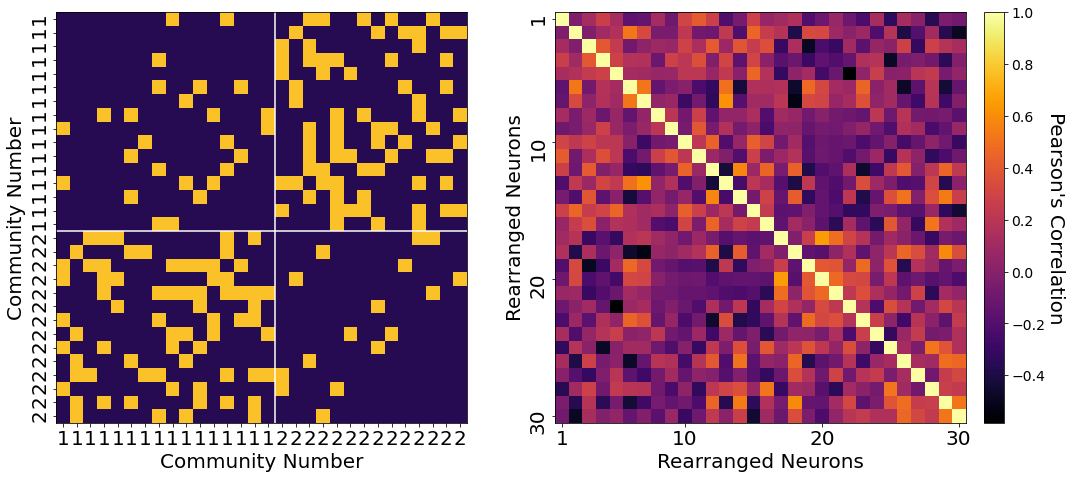

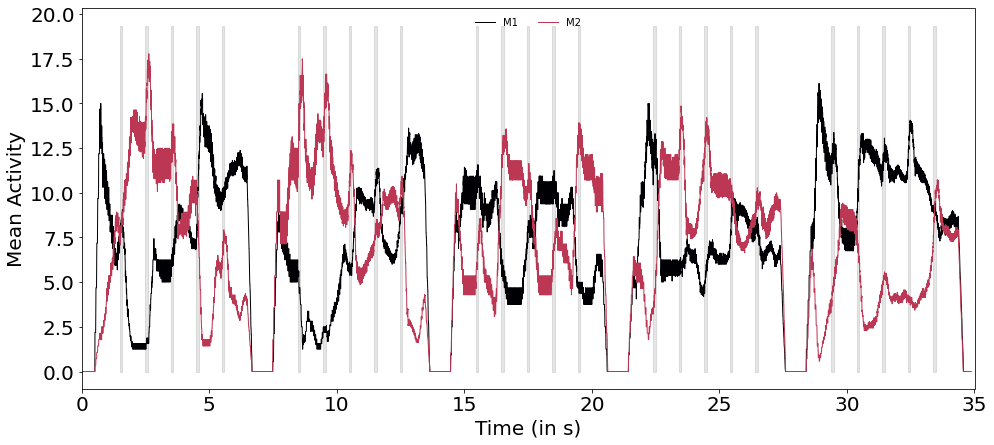

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 5/5 [00:00<00:00, 41.01it/s]


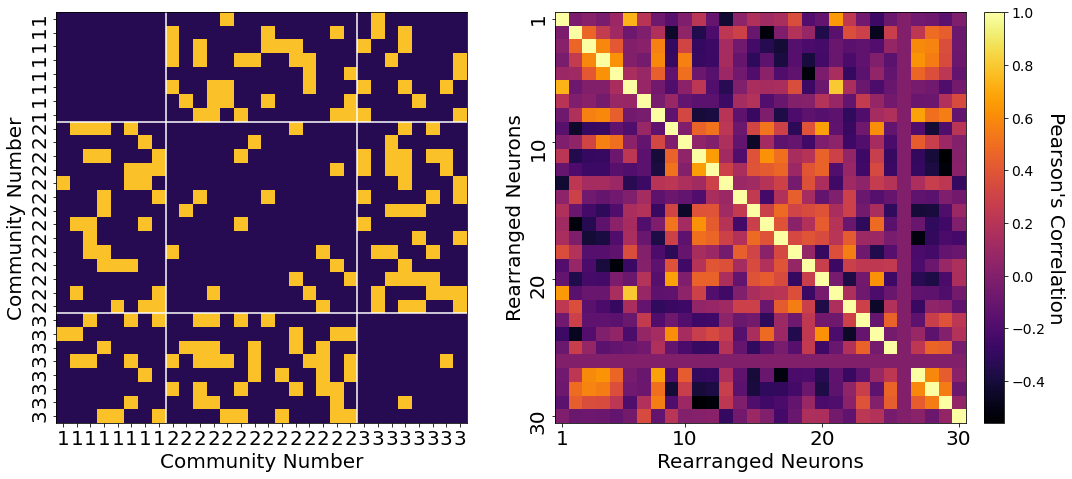

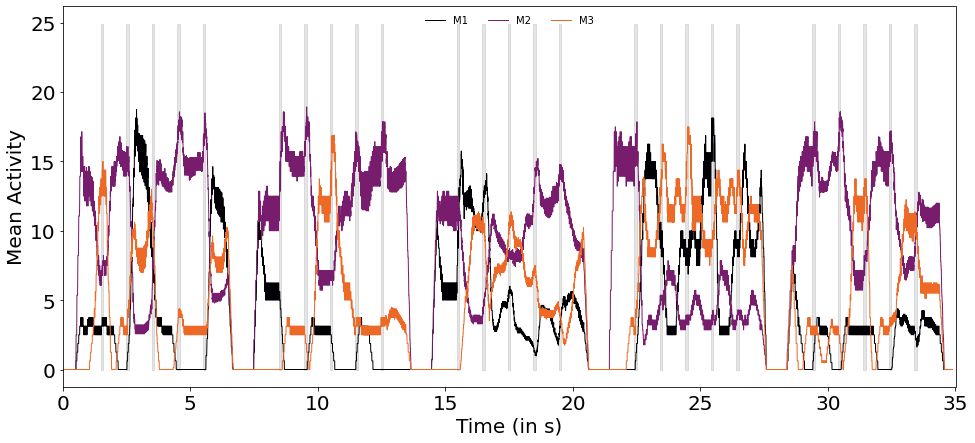

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 42.89it/s]


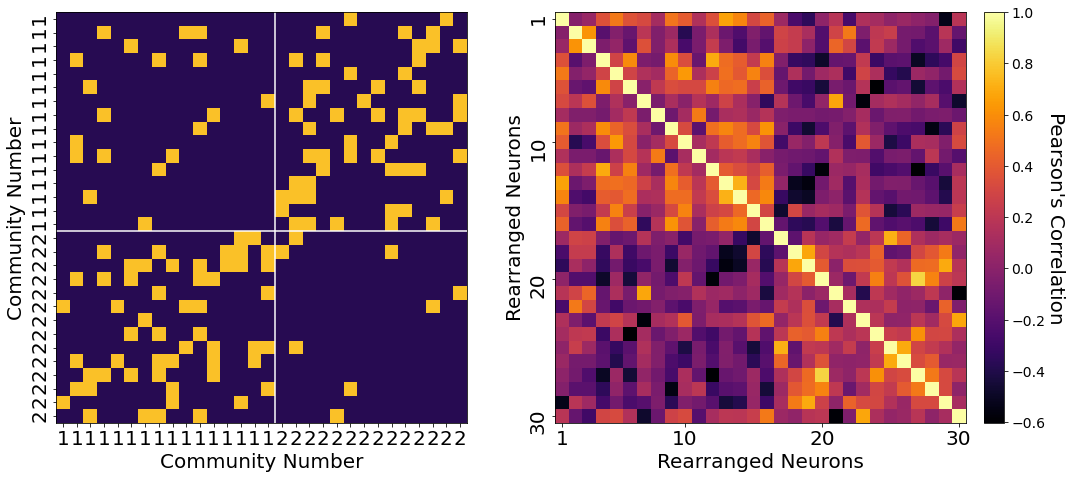

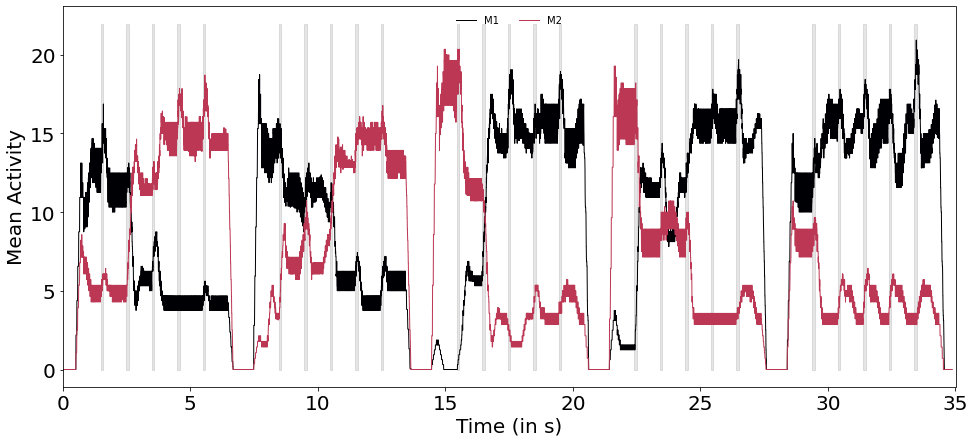

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 5/5 [00:00<00:00, 30.84it/s]


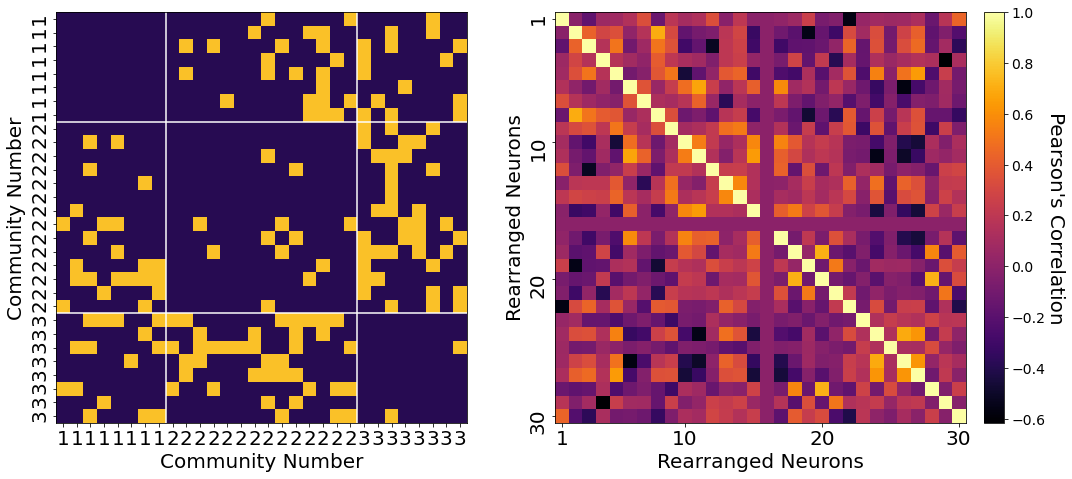

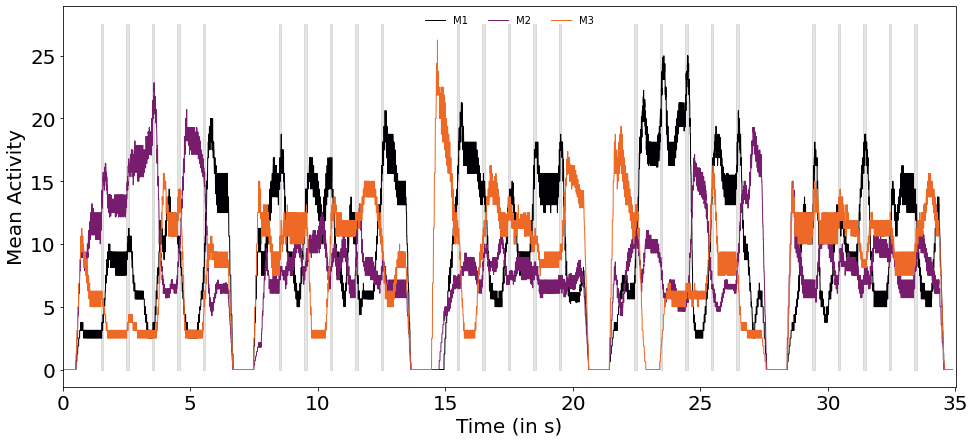

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 42.21it/s]


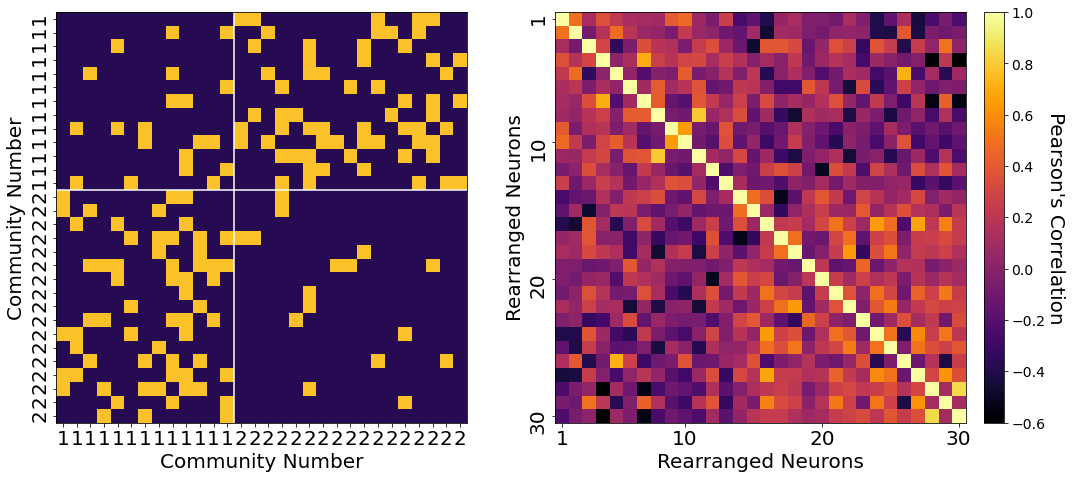

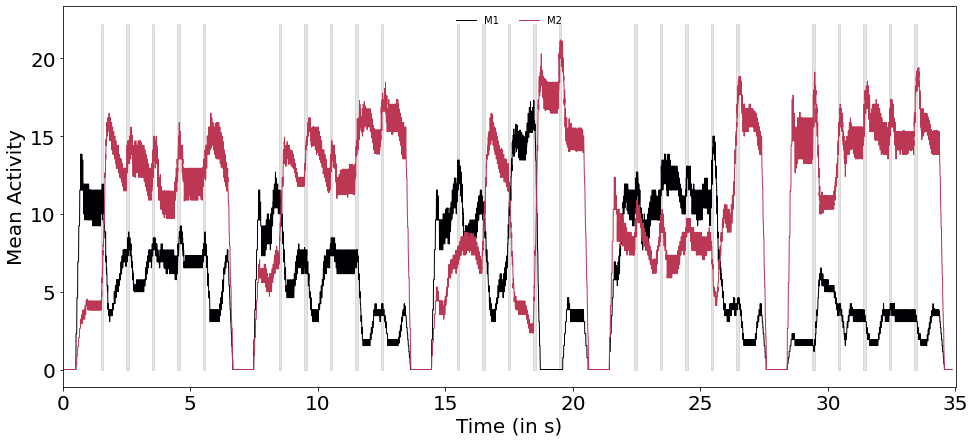

In [3]:
perts = []
for i in range(5):
    for j in range(5):
        perts.append(6.972*i+1.494+j)

for graphno in range(1,11):
    mat,module,order,sync,axs = eval_dynamics(graphno)
    sync = sync.mean(axis=0)
    fig = plt.figure(figsize=(15.5,7))
    fig.add_subplot(1,2,1)
    plt.imshow(mat[order,:][:,order],aspect='equal',cmap=plt.cm.inferno)
    plt.clim((-0.2,1.2))
    for i in np.arange(29)[np.diff(np.sort(module))==1]:
        plt.hlines(i+0.5,-0.5,29.5,color='white')
        plt.vlines(i+0.5,-0.5,29.5,color='white')
    plt.xticks(np.arange(30),[f"{x:.0f}" for x in np.sort(module)])
    plt.xlabel('Community Number')
    plt.yticks(np.arange(30),[f"{x:.0f}"for x in np.sort(module)],rotation=90)
    plt.ylabel('Community Number')
    fig.add_subplot(1,2,2)
    plt.imshow(sync[order,:][:,order],aspect='equal',cmap=plt.cm.inferno)
    plt.xticks([0,9,19,29],[1,10,20,30])
    plt.xlabel('Rearranged Neurons')
    plt.yticks([0,9,19,29],[1,10,20,30],rotation=90)
    plt.ylabel('Rearranged Neurons')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14) 
    cbar.set_label("Pearson's Correlation", rotation=270,labelpad=20)
    plt.savefig(f"Figures/Structure_Dynamics_{graphno}.svg")
    plt.tight_layout()
    plt.show()
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(1,1,1)
    for i in range(axs.shape[1]):
        ax.plot(np.arange(axs.shape[2])/1000,axs.mean(axis=0)[i],"-",color=plt.cm.inferno(i/axs.shape[1]),linewidth=1,label=f'M{i+1}')
    for pert in perts:
        ax.fill_betweenx((0,1.05*np.max(axs)),pert,pert+0.0996,color='k',alpha=0.1)
    plt.legend(loc='upper center', ncol=axs.shape[1], fontsize=10, frameon=False)
    ax.set_xlim((0,35))
    ax.set_xlabel("Time (in s)")
    ax.set_ylabel("Mean Activity")
    plt.savefig(f"Figures/Dynamics_{graphno}.svg")
    plt.show()

# Correlation Analysis (Fig 4c)

In [4]:
if recalculate:
    results = []
    for i in range(1,11):
        mat,module,order,sync,axs = eval_dynamics(i)
        for j in range(5):
            correlation = np.corrcoef(sync[j].flatten(),1-mat.flatten())[0,1]
            random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
            shuffled = np.mean([np.corrcoef(sync[j].flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
            results.append((correlation,shuffled))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv("AnalysedData/CorrelationAnalysis.csv")
else:
    results = pd.read_csv("AnalysedData/CorrelationAnalysis.csv",index_col=0)

In [5]:
eff,(eff_lci,eff_uci)=rankbiserial(results["Original"].values,results["Shuffled"].values)
print(f"{eff:0.3f} [95% CI {eff_lci:0.3f}-{eff_uci:0.3f}]")

1.000 [95% CI 1.000-1.000]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Original vs. Shuffled: Wilcoxon test (paired samples), P_val:7.557e-10 Stat=0.000e+00


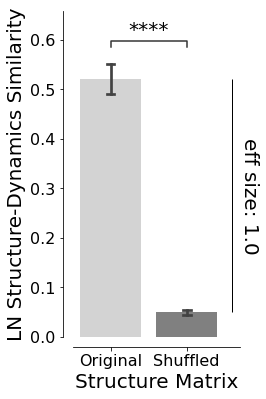

In [6]:
plt.figure(figsize=(3,6))
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
ax = sns.barplot(data=results,palette='blend:lightgrey,grey',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_xlabel("Structure Matrix")
ax.set_ylabel("LN Structure-Dynamics Similarity")
annotator = Annotator(ax, [("Original", "Shuffled")], data=results)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.vlines(1.6,results["Shuffled"].mean(),results["Original"].mean(),linewidth=1,colors='k')
plt.text(1.7,results.values.mean(),f"eff size: {eff}",rotation=270,va='center')
plt.savefig(f"Figures/CorrelationAnalysis.svg")

# Reconstruction Analysis (Fig 4f)

In [7]:
if recalculate:
    results = []
    for i in range(1,11):
        mat,module,order,sync,axs = eval_dynamics(i)
        for j in range(5):
            cluster_model = KMeans(n_clusters=int(np.max(module)))
            cluster_model.fit((1-sync[j])/2)
            f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
            random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
            shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
            results.append((f_correctpairs,shuffled))
    results = np.array(results)
    results = pd.DataFrame(results,columns=["Newman","Random"])
    results.to_csv("AnalysedData/ReconstructionAnalysis.csv")
else:
    results = pd.read_csv("AnalysedData/ReconstructionAnalysis.csv",index_col=0)

In [8]:
eff,(eff_lci,eff_uci)=rankbiserial(results["Newman"].values,results["Random"].values)
print(f"{eff:0.3f} [95% CI {eff_lci:0.3f}-{eff_uci:0.3f}]")

0.956 [95% CI 0.896-0.991]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Newman vs. Random: Wilcoxon test (paired samples), P_val:4.013e-09 Stat=2.800e+01


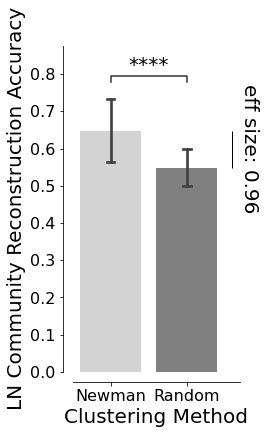

In [9]:
plt.figure(figsize=(3,6))
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
ax = sns.barplot(data=results,palette='blend:lightgrey,grey',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_xlabel("Clustering Method")
ax.set_ylabel("LN Community Reconstruction Accuracy")
annotator = Annotator(ax, [("Newman","Random")], data=results)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.vlines(1.6,results["Random"].mean(),results["Newman"].mean(),linewidth=1,colors='k')
plt.text(1.7,results.values.mean(),f"eff size: {eff:0.2f}",rotation=270,va='center')
plt.savefig(f"Figures/ReconstructionAnalysis.svg")

# Community Reconstruction (Fig 4d,e)

In [10]:
graphno = 2
mat = np.loadtxt(f'../modules/networks/matrix_{graphno}.csv',delimiter=",")
module = np.loadtxt(f'../modules/networks/matrix_{graphno}_modules.csv')
order = np.argsort(module)

all_events = []
for pertseed in [59428,13674,84932,72957,85036]:
    events = np.load(f"../data/30LN/LN30_events_{graphno}_{pertseed}.npy",allow_pickle=True)
    all_events.append(events)
all_events = np.array(all_events,dtype=object)

dist = []
for rep in tqdm(range(5)):
    spike_times = []
    for i in range(30):
        spike_times.append(SpikeTrain(np.concatenate([all_events[0,rep,i],
                                           all_events[1,rep,i]+7000,
                                           all_events[2,rep,i]+14000,
                                           all_events[3,rep,i]+21000,
                                           all_events[4,rep,i]+28000])*q.ms,t_stop=35000*q.ms))
    spike_times = np.array(spike_times)
    bst = eph.conversion.BinnedSpikeTrain(list(spike_times),bin_size=50*q.ms)
    sync = eph.spike_train_correlation.correlation_coefficient(bst)
    dist.append(sync)
distance_matrix = np.array(dist)
sync = np.mean(distance_matrix,axis=0)
cluster_model = KMeans(n_clusters=int(np.max(module)))
cluster_model.fit((1-sync)/2)
order2 = np.argsort(cluster_model.labels_)

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-10-e8a4a15fec27>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 44.23it/s]


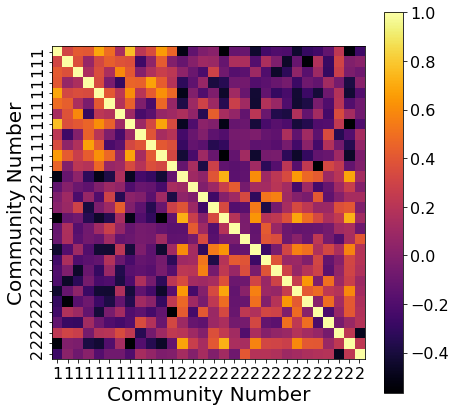

In [11]:
fig = plt.figure(figsize=(7,7))
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
plt.imshow(sync[order2,:][:,order2],aspect='equal',cmap=plt.cm.inferno)
plt.xticks(np.arange(30),[f"{x:.0f}" for x in np.sort(cluster_model.labels_+1)])
plt.xlabel('Community Number')
plt.yticks(np.arange(30),[f"{x:.0f}" for x in np.sort(cluster_model.labels_+1)],rotation=90)
plt.ylabel('Community Number')
plt.colorbar()
plt.savefig(f"Figures/ReconstructionCluster{graphno}.svg")

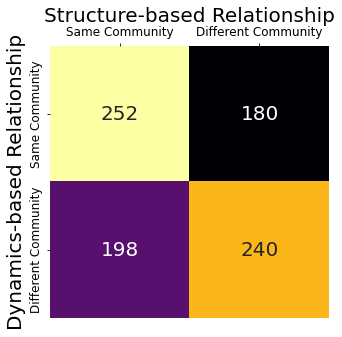

In [12]:
plt.figure(figsize=(5,5))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
ax = sns.heatmap(pair_confusion_matrix(cluster_model.labels_,np.int32(module-1)),annot=True,fmt="d",cbar=False,cmap=plt.cm.inferno)
plt.xticks([0.5,1.5],["Same Community","Different Community"])
plt.yticks([0.5,1.5],["Same Community","Different Community"],va='center')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.xlabel("Structure-based Relationship")
plt.ylabel("Dynamics-based Relationship")
plt.savefig(f"Figures/ReconstructionComparision.svg")

# Community Dynamics (Fig 4g,h)

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-2-dfa174075ccf>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array(spike_times)
100%|██████████| 5/5 [00:00<00:00, 41.65it/s]


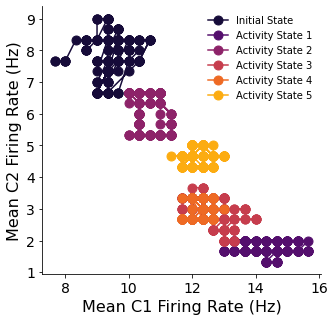

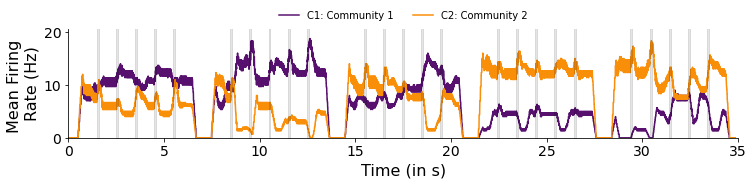

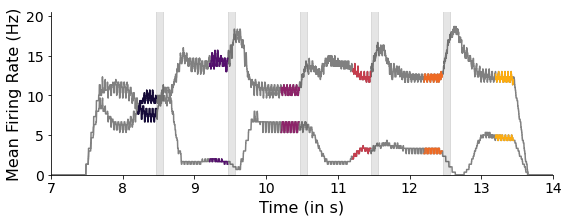

In [13]:
mat,module,order,sync,axs = eval_dynamics(2,)
mpl.rcParams.update({'font.size': 16})
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 
plt.figure(figsize=(5,5))
labels = ["Initial State"]+ [f"Activity State {i}" for i in range(1,6)]
for i,label in enumerate(labels):
    plt.plot(axs[0][0][6972+498+996*i+747:6972+498+996*i+996+1],
             axs[0][1][6972+498+996*i+747:6972+498+996*i+996+1],
             "o-",markersize=9,color=plt.cm.inferno(0.1+i/7.0),alpha=1,label=label)
plt.gca().set_aspect('equal')
plt.xlabel("Mean C1 Firing Rate (Hz)")
plt.ylabel("Mean C2 Firing Rate (Hz)")
plt.legend(fontsize=10,frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig("Figures/Representation_Set2_Graph2.svg")
plt.show()

plt.figure(figsize=(12,2))
perts = []
for i in range(5):
    for j in range(5):
        perts.append(6.972*i+1.494+j)
for pert in perts:
    plt.fill_betweenx((0,1.3*np.max(axs[0])),pert,pert+0.0996,color='k',alpha=0.1,zorder=3)
plt.plot(np.arange(axs[0][0].shape[0])/1000,axs[0][0],color=plt.cm.inferno(0.25),label='C1: Community 1')
plt.plot(np.arange(axs[0][0].shape[0])/1000,axs[0][1],color=plt.cm.inferno(0.75),label='C2: Community 2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("Time (in s)")
plt.ylabel("Mean Firing \nRate (Hz)")
plt.xlim(0,35)
plt.ylim(0,1.1*np.max(axs[0]))
plt.legend(fontsize=10,frameon=False,loc='upper center',ncol=2,
          bbox_to_anchor=(0.5, 1.25))
plt.savefig("Figures/Perturbations_Fig_Graph2.svg")
plt.show()

plt.figure(figsize=(9,3))
perts = []
for i in [1]:
    for j in range(5):
        perts.append(6.972*i+1.494+j)
for pert in perts:
    plt.fill_betweenx((0,1.3*np.max(axs[0])),pert,pert+0.0996,color='k',alpha=0.1,zorder=3)

plt.plot(np.arange(axs[0][0].shape[0])/1000,axs[0][0],color='grey')
plt.plot(np.arange(axs[0][0].shape[0])/1000,axs[0][1],color='grey')
labels = ["Initial State"]+ [f"Perturbation {i}" for i in range(1,6)]
for i,label in enumerate(labels):
    plt.plot(np.arange(6972+498+996*i+747,6972+498+996*i+997)/1000,
             axs[0][0][6972+498+996*i+747:6972+498+996*i+996+1],
             color=plt.cm.inferno(0.1+i/7.0),alpha=1,label=label)
    plt.plot(np.arange(6972+498+996*i+747,6972+498+996*i+997)/1000,
             axs[0][1][6972+498+996*i+747:6972+498+996*i+996+1],
             color=plt.cm.inferno(0.1+i/7.0),alpha=1,label=label)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("Time (in s)")
plt.ylabel("Mean Firing Rate (Hz)")
plt.xlim(7,14)
plt.ylim(0,1.1*np.max(axs[0]))
plt.savefig("Figures/Perturbations_Set2_Graph2.svg")
plt.show()
